In [1]:
import numpy as np
import sys
from collections import Counter
import re
import nltk
import pandas as pd
from nltk.corpus import stopwords
import math
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import contractions
import re
import spacy
from spacy import displacy
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import time
import keras
from keras.models import Model
from keras.layers import Input
from keras import layers
from keras.layers import Dense
from keras.optimizers import SGD

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pburn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pburn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\pburn\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# Reading in dataset
movie_df = pd.read_csv("movie.csv")
movie_df.head()
movie_df = movie_df[['text', 'label']]
# yelp_df['stars'] = yelp_df['stars'].apply(str)
movie_df.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [3]:
def apply_lowercase(text):
    new_text = text.lower()
    return new_text

In [4]:
movie_df['text'] = movie_df['text'].apply(apply_lowercase)
#yelp_df['text'] = yelp_df['text'].apply(apply_space_tokenization)
movie_df = movie_df[0:5000]
movie_df

,text,label
0,i grew up (b. 1965) watching and loving the th...,0
1,"when i put this movie in my dvd player, and sa...",0
2,why do people who do not know what a particula...,0
3,even though i have great interest in biblical ...,0
4,im a die hard dads army fan and nothing will e...,1
...,...,...
4995,absolutely putrid slasher film has not one red...,0
4996,one of frances farmer's earliest movies; at 22...,0
4997,i rented this thinking it would be pretty good...,0
4998,we went into this movie because my husband had...,0


# Preprocessing Expirements
#### Potentially we do some constants throughout our experiments? I.e Tokenize just by spaces, and lowecase all

In [5]:
# Pre-Processing Globals
STOP_WORDS = set(stopwords.words('english'))
NER = spacy.load("en_core_web_sm")
LEM = WordNetLemmatizer()
PS = PorterStemmer()

### No Pre-Processing

### Lemanization

In [6]:
def apply_lem(text):
    new_text = []
    for word in text.split(' '):
        new_word = LEM.lemmatize(word)
        new_text.append(new_word)
    review = ' '.join(new_text)
    return review

### Stemming

In [7]:
def apply_stemming(text):
    new_text = []
    for word in text.split(' '):
        new_word = PS.stem(word)
        new_text.append(new_word)
    review = ' '.join(new_text)
    return review

### Contraction expansion

In [8]:
def apply_contraction_expansion(text):
    new_text = []
    for word in text.split(' '):
        new_word = contractions.fix(text)
        new_text.append(new_word)
    review = ' '.join(new_text)
    return review

### Removing Number related text

In [9]:
def apply_number_removal(text):
    review = re.sub(r'[0-9]', '', text)
    return review

### Punctuation Removal

In [10]:
def apply_punctuation_removal(text):
    review = re.sub(r'[.,!?-_;:&#$@%=+]', '', text)
    return review

### Stopword Removal

In [11]:
def apply_stopword_removal(text):
    new_text = []
    for word in text.split(' '):
        if text in STOP_WORDS:
            continue
        else:
            new_text.append(word)
    review = ' '.join(new_text)
    return review

### NER AND POS TAGGING

In [12]:
def apply_spacy(text):
    applied_text = NER(text)
    return applied_text.text


def get_pos(spacy_text):
    new_sentence = []
    excluded_tags = {"NOUN", "PRON", "PROPN", "DET", "ADP", "PUNCT",}
    for word in spacy_text:
        if word.pos_ not in excluded_tags:
            new_sentence.append(word.text)
    review = ' '.join(new_sentence)
    return review

# Model Creation & Test Execution

In [13]:
def report_metrics(gold_labels, predicted_labels, name, clf):
    labels = [0, 1]
    # Reporting metrics & confusion matrix
    acc = round(accuracy_score(gold_labels, predicted_labels), 4)
    err = round(1 - acc, 4)
    pre = round(precision_score(gold_labels, predicted_labels), 4)
    rec = round(recall_score(gold_labels, predicted_labels), 4)
    f1 = round(f1_score(gold_labels, predicted_labels), 4)

    print("Accuracy: ", acc)
    print("Error: ", err)
    print("Precision: ", pre)
    print("Recall: ", rec)
    print("F1-Score: ", f1)

    cf_matrix = confusion_matrix(gold_labels, predicted_labels, labels=labels)
    rcParams['figure.figsize'] = (6, 4)
    sns.heatmap(cf_matrix, annot=True, cmap="Greens", xticklabels=labels, yticklabels=labels, fmt='g')
    plt.title(name)
    plt.ylabel("True Labels")
    plt.xlabel("Predicted Labels")
    plt.show()
    
    return acc, err, pre, rec, f1

In [14]:
def setup_experiment(text, labels, pre_processing_step):
    if pre_processing_step == "None":
        corpus = text
        vectorizer = CountVectorizer(max_features=500)
        X = vectorizer.fit_transform(corpus).toarray()
        y = labels
        
        return X, y, 0
    
    # Creating a corpus (list of documents)
    start_time = time.time()
    corpus = list((map(pre_processing_step, text)))
    end_time = time.time()
    print(end_time-start_time)
    
    # Using BOW representation
    vectorizer = CountVectorizer(max_features=500)
    
    X = vectorizer.fit_transform(corpus).toarray()
    y = labels
    
    return X, y, end_time - start_time

In [15]:
def run_experiment(X, y, model_name, time):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)
    
    if model_name == 'NB':
        model = MultinomialNB()
        # Running experiment
        model.fit(X_train, y_train)
    
        # Make predictions
        predictions = model.predict(X_test)
        
        # Calculating metrics
        acc, err, pre, rec, f1 = report_metrics(y_test, predictions, model_name, model)
        
        return acc, err, pre, rec, f1, time
    
    elif model_name == 'Deep':
        model = keras.Sequential([
        layers.Dense(400, activation="relu"),
        layers.Dense(400, activation="relu"),
        layers.Dense(200, activation="relu"),
        layers.Dense(1, activation="sigmoid")])
        model.compile(loss='binary_crossentropy', optimizer=SGD(lr=0.01, momentum=0.9), metrics=['accuracy'])
        
        # Running experiment
        model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1)
        
        # Make predictions
        predictions = model.predict_classes(X_test)
        
        # Calculating metrics
        acc, err, pre, rec, f1 = report_metrics(y_test, predictions, model_name, model)
        
        return acc, err, pre, rec, f1, time
    else:
        pass

None
Epoch 1/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6760 - accuracy: 0.6022
Epoch 2/10
40/40 [==============================] - 0s 3ms/step - loss: 0.5737 - accuracy: 0.7132
Epoch 3/10
40/40 [==============================] - 0s 3ms/step - loss: 0.5188 - accuracy: 0.7540
Epoch 4/10
40/40 [==============================] - 0s 3ms/step - loss: 0.4804 - accuracy: 0.7810
Epoch 5/10
40/40 [==============================] - 0s 3ms/step - loss: 0.4362 - accuracy: 0.7995
Epoch 6/10
40/40 [==============================] - 0s 4ms/step - loss: 0.4052 - accuracy: 0.8192
Epoch 7/10
40/40 [==============================] - 0s 4ms/step - loss: 0.3636 - accuracy: 0.8410
Epoch 8/10
40/40 [==============================] - 0s 3ms/step - loss: 0.3205 - accuracy: 0.8658
Epoch 9/10
40/40 [==============================] - 0s 3ms/step - loss: 0.3513 - accuracy: 0.8490
Epoch 10/10
40/40 [==============================] - 0s 4ms/step - loss: 0.3320 - accuracy: 0.8587
Instructions f

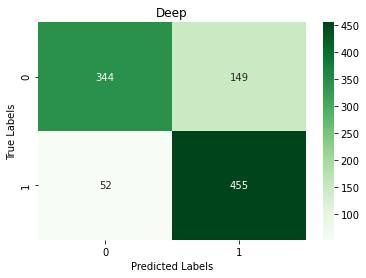

lem
7.587049722671509
Epoch 1/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6618 - accuracy: 0.6022
Epoch 2/10
40/40 [==============================] - 0s 3ms/step - loss: 0.5970 - accuracy: 0.7015
Epoch 3/10
40/40 [==============================] - 0s 3ms/step - loss: 0.5999 - accuracy: 0.6913
Epoch 4/10
40/40 [==============================] - 0s 3ms/step - loss: 0.4851 - accuracy: 0.7775
Epoch 5/10
40/40 [==============================] - 0s 3ms/step - loss: 0.4491 - accuracy: 0.7935
Epoch 6/10
40/40 [==============================] - 0s 3ms/step - loss: 0.4161 - accuracy: 0.8158
Epoch 7/10
40/40 [==============================] - 0s 3ms/step - loss: 0.3704 - accuracy: 0.8388
Epoch 8/10
40/40 [==============================] - 0s 3ms/step - loss: 0.3430 - accuracy: 0.8597
Epoch 9/10
40/40 [==============================] - 0s 3ms/step - loss: 0.3534 - accuracy: 0.8403
Epoch 10/10
40/40 [==============================] - 0s 3ms/step - loss: 0.2987 - accuracy: 0.87

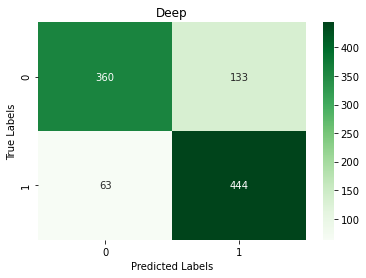

stemming
26.049150228500366
Epoch 1/10
40/40 [==============================] - 0s 4ms/step - loss: 0.6514 - accuracy: 0.6263
Epoch 2/10
40/40 [==============================] - 0s 3ms/step - loss: 0.5836 - accuracy: 0.7075
Epoch 3/10
40/40 [==============================] - 0s 3ms/step - loss: 0.4925 - accuracy: 0.7775
Epoch 4/10
40/40 [==============================] - 0s 4ms/step - loss: 0.4719 - accuracy: 0.7857
Epoch 5/10
40/40 [==============================] - 0s 3ms/step - loss: 0.4636 - accuracy: 0.7970
Epoch 6/10
40/40 [==============================] - 0s 3ms/step - loss: 0.4074 - accuracy: 0.8232
Epoch 7/10
40/40 [==============================] - 0s 3ms/step - loss: 0.3964 - accuracy: 0.8263
Epoch 8/10
40/40 [==============================] - 0s 3ms/step - loss: 0.3795 - accuracy: 0.8317
Epoch 9/10
40/40 [==============================] - 0s 3ms/step - loss: 0.3703 - accuracy: 0.8450
Epoch 10/10
40/40 [==============================] - 0s 3ms/step - loss: 0.3223 - accuracy

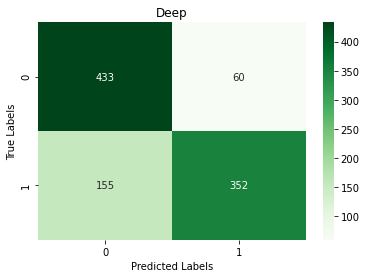

contraction_expansion
182.40075945854187
Epoch 1/10
40/40 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.5200
Epoch 2/10
40/40 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.5222
Epoch 3/10
40/40 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.5222
Epoch 4/10
40/40 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.5222
Epoch 5/10
40/40 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.5222
Epoch 6/10
40/40 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.5222
Epoch 7/10
40/40 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.5222
Epoch 8/10
40/40 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.5222
Epoch 9/10
40/40 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.5222
Epoch 10/10
40/40 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.5222
Accuracy

C:\Users\pburn\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


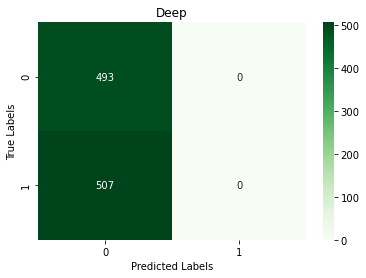

number_removal
0.07081270217895508
Epoch 1/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6440 - accuracy: 0.6335
Epoch 2/10
40/40 [==============================] - 0s 3ms/step - loss: 0.5725 - accuracy: 0.7125
Epoch 3/10
40/40 [==============================] - 0s 3ms/step - loss: 0.5099 - accuracy: 0.7632
Epoch 4/10
40/40 [==============================] - 0s 3ms/step - loss: 0.4997 - accuracy: 0.7640
Epoch 5/10
40/40 [==============================] - 0s 3ms/step - loss: 0.4233 - accuracy: 0.8075
Epoch 6/10
40/40 [==============================] - 0s 3ms/step - loss: 0.3692 - accuracy: 0.8390
Epoch 7/10
40/40 [==============================] - 0s 3ms/step - loss: 0.3514 - accuracy: 0.8495
Epoch 8/10
40/40 [==============================] - 0s 3ms/step - loss: 0.3468 - accuracy: 0.8512
Epoch 9/10
40/40 [==============================] - 0s 3ms/step - loss: 0.3162 - accuracy: 0.8662
Epoch 10/10
40/40 [==============================] - 0s 3ms/step - loss: 0.3742 - a

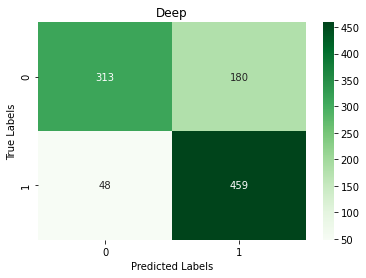

punctuation_removal
0.08178186416625977
Epoch 1/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6730 - accuracy: 0.5920
Epoch 2/10
40/40 [==============================] - 0s 3ms/step - loss: 0.5684 - accuracy: 0.7090
Epoch 3/10
40/40 [==============================] - 0s 3ms/step - loss: 0.5015 - accuracy: 0.7628
Epoch 4/10
40/40 [==============================] - 0s 3ms/step - loss: 0.4679 - accuracy: 0.7910
Epoch 5/10
40/40 [==============================] - 0s 3ms/step - loss: 0.4542 - accuracy: 0.7983
Epoch 6/10
40/40 [==============================] - 0s 3ms/step - loss: 0.4283 - accuracy: 0.8060
Epoch 7/10
40/40 [==============================] - 0s 3ms/step - loss: 0.4384 - accuracy: 0.8070
Epoch 8/10
40/40 [==============================] - 0s 3ms/step - loss: 0.3890 - accuracy: 0.8322
Epoch 9/10
40/40 [==============================] - 0s 3ms/step - loss: 0.3179 - accuracy: 0.8597
Epoch 10/10
40/40 [==============================] - 0s 3ms/step - loss: 0.293

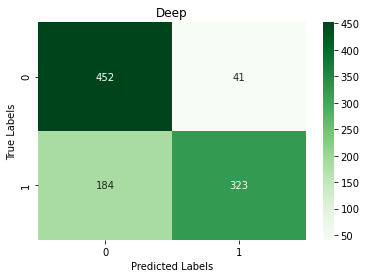

stopword_removal
0.25032973289489746
Epoch 1/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6778 - accuracy: 0.5997
Epoch 2/10
40/40 [==============================] - 0s 3ms/step - loss: 0.5924 - accuracy: 0.6930
Epoch 3/10
40/40 [==============================] - 0s 3ms/step - loss: 0.5167 - accuracy: 0.7530
Epoch 4/10
40/40 [==============================] - 0s 3ms/step - loss: 0.5145 - accuracy: 0.7552
Epoch 5/10
40/40 [==============================] - 0s 3ms/step - loss: 0.4666 - accuracy: 0.7890
Epoch 6/10
40/40 [==============================] - 0s 3ms/step - loss: 0.4128 - accuracy: 0.8190
Epoch 7/10
40/40 [==============================] - 0s 3ms/step - loss: 0.3836 - accuracy: 0.8395
Epoch 8/10
40/40 [==============================] - 0s 3ms/step - loss: 0.3621 - accuracy: 0.8453
Epoch 9/10
40/40 [==============================] - 0s 3ms/step - loss: 0.3547 - accuracy: 0.8475
Epoch 10/10
40/40 [==============================] - 0s 3ms/step - loss: 0.3519 -

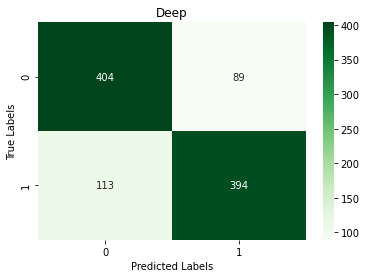

pos_removal
198.731347322464
Epoch 1/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6349 - accuracy: 0.6455
Epoch 2/10
40/40 [==============================] - 0s 3ms/step - loss: 0.5799 - accuracy: 0.7113
Epoch 3/10
40/40 [==============================] - 0s 3ms/step - loss: 0.5051 - accuracy: 0.7592
Epoch 4/10
40/40 [==============================] - 0s 3ms/step - loss: 0.4466 - accuracy: 0.7977
Epoch 5/10
40/40 [==============================] - 0s 3ms/step - loss: 0.4494 - accuracy: 0.7955
Epoch 6/10
40/40 [==============================] - 0s 3ms/step - loss: 0.4598 - accuracy: 0.7947
Epoch 7/10
40/40 [==============================] - 0s 3ms/step - loss: 0.4447 - accuracy: 0.7935
Epoch 8/10
40/40 [==============================] - 0s 3ms/step - loss: 0.3415 - accuracy: 0.8565
Epoch 9/10
40/40 [==============================] - 0s 3ms/step - loss: 0.3305 - accuracy: 0.8602
Epoch 10/10
40/40 [==============================] - 0s 3ms/step - loss: 0.2998 - accurac

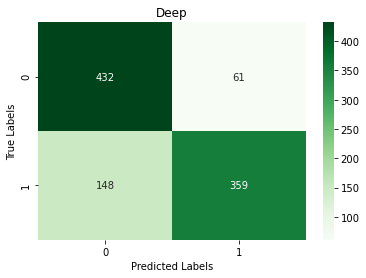

None
Accuracy:  0.776
Error:  0.224
Precision:  0.7847
Recall:  0.7692
F1-Score:  0.7769


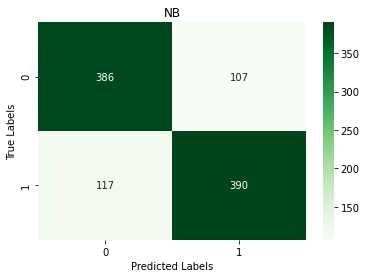

lem
5.446049213409424
Accuracy:  0.778
Error:  0.222
Precision:  0.7902
Recall:  0.7653
F1-Score:  0.7776


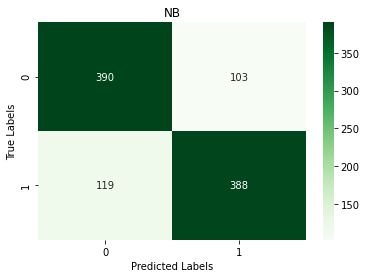

stemming
24.122233867645264
Accuracy:  0.761
Error:  0.239
Precision:  0.7769
Recall:  0.7416
F1-Score:  0.7588


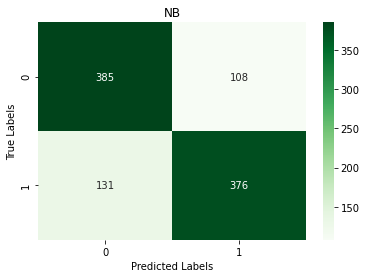

contraction_expansion
175.74615502357483
Accuracy:  0.726
Error:  0.274
Precision:  0.7618
Recall:  0.6686
F1-Score:  0.7122


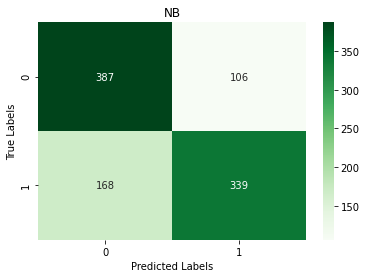

number_removal
0.06186795234680176
Accuracy:  0.776
Error:  0.224
Precision:  0.7836
Recall:  0.7712
F1-Score:  0.7773


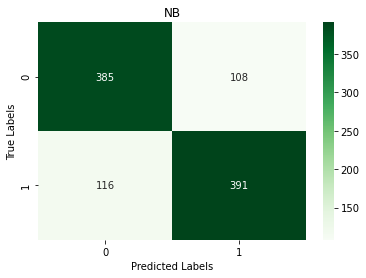

punctuation_removal
0.07380318641662598
Accuracy:  0.782
Error:  0.218
Precision:  0.7884
Recall:  0.7791
F1-Score:  0.7837


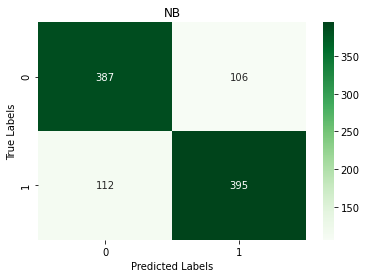

stopword_removal
0.2429511547088623
Accuracy:  0.776
Error:  0.224
Precision:  0.7847
Recall:  0.7692
F1-Score:  0.7769


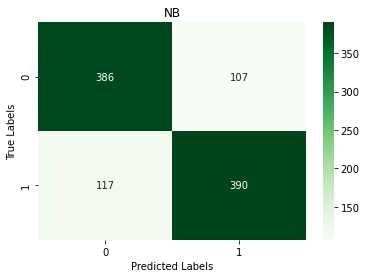

pos_removal
192.6488687992096
Accuracy:  0.776
Error:  0.224
Precision:  0.7847
Recall:  0.7692
F1-Score:  0.7769


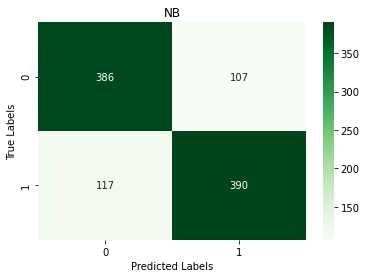

In [16]:
# Pre-processing options
# apply_spelling_correction
options = ['None', apply_lem, apply_stemming, apply_contraction_expansion, apply_number_removal,
          apply_punctuation_removal, apply_stopword_removal, apply_spacy]
options_string = ['None', 'lem', 'stemming', 'contraction_expansion', 'number_removal',
          'punctuation_removal', 'stopword_removal', 'pos_removal']

columns = ['Pre-Processing', 'Acuracy', 'Error', 'Precision', 'Recall', 'F1-Score', 'Time']

results_df = pd.DataFrame(columns=columns)

text = movie_df['text'].to_numpy()
labels = movie_df['label'].to_numpy()

# Running experiments for Neural Network model
for option, name in zip(options, options_string):
    print(name)
    X, y, t = setup_experiment(text, labels, option)
    acc, err, pre, rec, f1, t  = run_experiment(X, y, "Deep", t)
    df_dict = {'Pre-Processing':"Deep-"+name, 'Acuracy':acc, 'Error':err, 'Precision':pre, 
               'Recall':rec, 'F1-Score':f1, 'Time':t}
    results_df = results_df.append(df_dict, ignore_index=True)
    
# Running experiments for Naive Bayes model
for option, name in zip(options, options_string):
    print(name)
    X, y, t = setup_experiment(text, labels, option)
    acc, err, pre, rec, f1, t  = run_experiment(X, y, "NB", t)
    df_dict = {'Pre-Processing':"NB-"+name, 'Acuracy':acc, 'Error':err, 'Precision':pre, 
               'Recall':rec, 'F1-Score':f1, 'Time':t}
    results_df = results_df.append(df_dict, ignore_index=True)

In [17]:
results_df

,Pre-Processing,Acuracy,Error,Precision,Recall,F1-Score,Time
0,Deep-None,0.799,0.201,0.7533,0.8974,0.8191,0
1,Deep-lem,0.804,0.196,0.7695,0.8757,0.8192,7.58705
2,Deep-stemming,0.785,0.215,0.8544,0.6943,0.7661,26.04915
3,Deep-contraction_expansion,0.493,0.507,0.0000,0.0000,0.0000,182.400759
4,Deep-number_removal,0.772,0.228,0.7183,0.9053,0.8010,0.070813
5,Deep-punctuation_removal,0.775,0.225,0.8874,0.6371,0.7417,0.081782
6,Deep-stopword_removal,0.798,0.202,0.8157,0.7771,0.7960,0.25033
7,Deep-pos_removal,0.791,0.209,0.8548,0.7081,0.7745,198.731347
8,NB-None,0.776,0.224,0.7847,0.7692,0.7769,0
9,NB-lem,0.778,0.222,0.7902,0.7653,0.7776,5.446049


In [2]:
accuracies_dict = {'Deep-None': 0.799, 'Deep-lem': 0.804, 'Deep-stemming': 0.785, 'Deep-contraction_expansion': 0.493, 'Deep-number_removal': 0.772, 'Deep-punctuation_removal': 0.775, 'Deep-stopword_removal': 0.798, 'Deep-pos_removal': 0.791, 'NB-None': 0.776, 'NB-lem': 0.778, 'NB-stemming': 0.761, 'NB-contraction_expansion': 0.726, 'NB-number_removal': 0.776, 'NB-punctuation_removal': 0.782, 
'NB-stopword_removal': 0.776, 'NB-pos_removal': 0.776}

results_dict = {'Deep-None': 0.8191, 'Deep-lem': 0.8192, 'Deep-stemming': 0.7661, 'Deep-contraction_expansion': 0.000, 'Deep-number_removal': 0.8010, 'Deep-punctuation_removal': 0.7417, 'Deep-stopword_removal': 0.7960, 'Deep-pos_removal': 0.7745, 'NB-None': 0.7769, 'NB-lem': 0.7776, 'NB-stemming': 0.7588, 'NB-contraction_expansion': 0.7122, 'NB-number_removal': 0.7773, 'NB-punctuation_removal': 0.7837, 
'NB-stopword_removal': 0.7769, 'NB-pos_removal': 0.7769}

# iterate through the f1 scores and split based on the model
deep_keys = []
deep_values = []

nb_keys = []
nb_values = []

for key, val in results_dict.items():
    if key.startswith('Deep'):
        deep_keys.append(key)
        deep_values.append(val)
    else:
        nb_keys.append(key)
        nb_values.append(val)
print(deep_keys)
print(nb_keys)


['Deep-None', 'Deep-lem', 'Deep-stemming', 'Deep-contraction_expansion', 'Deep-number_removal', 'Deep-punctuation_removal', 'Deep-stopword_removal', 'Deep-pos_removal']
['NB-None', 'NB-lem', 'NB-stemming', 'NB-contraction_expansion', 'NB-number_removal', 'NB-punctuation_removal', 'NB-stopword_removal', 'NB-pos_removal']


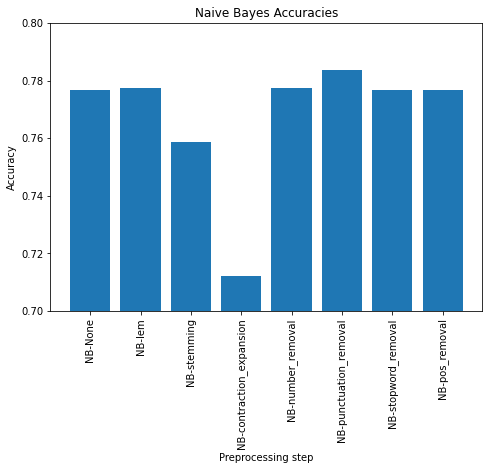

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(nb_keys, nb_values)
plt.xticks(rotation = 90)
ax.set_ylim([0.7, 0.80])


plt.xlabel('Preprocessing step') 
plt.ylabel('Accuracy') 
  
# displaying the title
plt.title("Naive Bayes Accuracies")
plt.show()

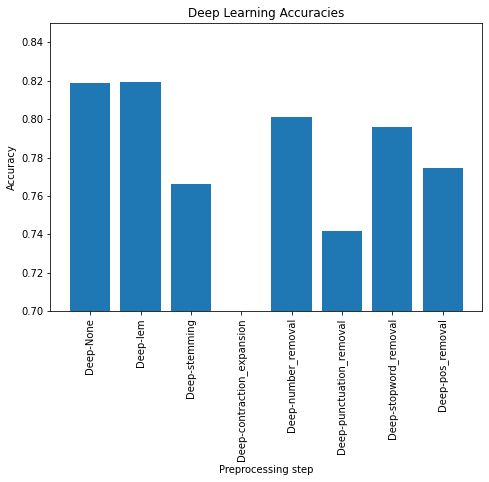

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(deep_keys, deep_values)
plt.xticks(rotation = 90)
ax.set_ylim([0.7, 0.85])


plt.xlabel('Preprocessing step') 
plt.ylabel('Accuracy') 
  
# displaying the title
plt.title("Deep Learning Accuracies")
plt.show()

In [5]:
# average time of preprocessing step across each model
preprocessing_time = {'None': 0, 'Lemmatization': 6.5165495, 'Stemming': 25.06, 'Contraction Expansion': 179.073, 'Number Removal': 0.0663, 'Punctuation Removal': 0.0718, 'Stopword Removal': 0.247, 'POS removal': 195.69}




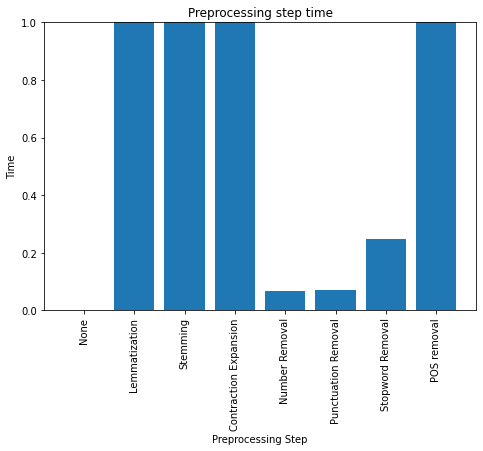

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(preprocessing_time.keys(), preprocessing_time.values())
plt.xticks(rotation = 90)
ax.set_ylim([0, 1])


plt.xlabel('Preprocessing Step') 
plt.ylabel('Time') 
  
# displaying the title
plt.title("Preprocessing step time")
plt.show()

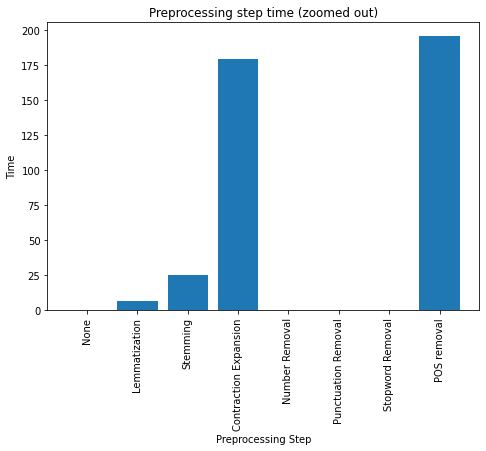

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(preprocessing_time.keys(), preprocessing_time.values())
plt.xticks(rotation = 90)
# ax.set_ylim([0, 1])


plt.xlabel('Preprocessing Step') 
plt.ylabel('Time') 
  
# displaying the title
plt.title("Preprocessing step time (zoomed out)")
plt.show()